# Environmental Sound Classification using Deep Learning
## >> Urban sound classification with CNNs


* [0. Load the preprocessed data](#zero-bullet)
* [1. Create a custom dataset class](#first-bullet)
* [2. Data augmentation](#first-bullet)
* [3. CNN model](#third-bullet)
* [4. Helper functions](#fourth-bullet)
* [5. 10-Fold Cross Validation](#fifth-bullet)
* [6. Results](#sixth-bullet)

---

In [ ]:
!pip install hypll

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
import os
import sys
import pickle
import copy

from datetime import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from hypll import nn as hnn
from hypll.optim import RiemannianAdam, RiemannianSGD
from hypll.tensors import TangentTensor, ManifoldParameter
# import seaborn as sns



import random

%matplotlib inline

In [ ]:
USE_GOOGLE_COLAB = True

if USE_GOOGLE_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

    # change the current working directory
    %cd gdrive/'My Drive'/US8K
else:
    %cd US8K

Mounted at /content/gdrive
/content/gdrive/My Drive/US8K


---

## 0. Load the preprocessed data <a name="zero-bullet"></a>

In [ ]:
us8k_df = pd.read_pickle("us8k_df.pkl")

In [ ]:
us8k_df.head()

,melspectrogram,label,fold
0,"[[-68.90541, -74.497375, -65.13373, -65.75191,...",3,5
1,"[[-17.173355, -3.6112595, -12.501212, -13.6347...",2,5
2,"[[-26.217117, -14.915922, -6.091381, -12.99589...",2,5
3,"[[-17.566685, -12.813037, -12.30004, -11.43900...",2,5
4,"[[-14.985781, 0.0, -11.1152115, -10.564413, -3...",2,5


---

## 1. Create a custom dataset class  <a name="first-bullet"></a>




In [ ]:
DEFAULT_SAMPLE_RATE = 22050

class UrbanSound8kDataset(Dataset):
    def __init__(self, us8k_df, transform=None):
        assert isinstance(us8k_df, pd.DataFrame)
        assert len(us8k_df.columns) == 3

        self.us8k_df = us8k_df
        self.transform = transform

    def __len__(self):
        return len(self.us8k_df)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        spectrogram, label, fold = self.us8k_df.iloc[index]

        if self.transform is not None:
            spectrogram = self.transform(spectrogram)

        return {'spectrogram': spectrogram, 'label':label}

---

## 2. Data augmentation


In [ ]:
class MyRightShift(object):
    """Shift the image to the right in time."""

    def __init__(self, input_size, width_shift_range, shift_probability=1.0):
        assert isinstance(input_size, (int, tuple))
        assert isinstance(width_shift_range, (int, float))
        assert isinstance(shift_probability, (float))

        if isinstance(input_size, int):
            self.input_size = (input_size, input_size)
        else:
            assert len(input_size) == 2
            self.input_size = input_size

        if isinstance(width_shift_range, int):
            assert width_shift_range > 0
            assert width_shift_range <= self.input_size[1]
            self.width_shift_range = width_shift_range
        else:
            assert width_shift_range > 0.0
            assert width_shift_range <= 1.0
            self.width_shift_range = int(width_shift_range * self.input_size[1])

        assert shift_probability > 0.0 and shift_probability <= 1.0
        self.shift_prob = shift_probability

    def __call__(self, image):
        if np.random.random() > self.shift_prob:
          return image

        # create a new array filled with the min value
        shifted_image= np.full(self.input_size, np.min(image), dtype='float32')

        # randomly choose a start postion
        rand_position = np.random.randint(1, self.width_shift_range)

        # shift the image
        shifted_image[:,rand_position:] = copy.deepcopy(image[:,:-rand_position])

        return shifted_image

class MyAddGaussNoise(object):
    """Add Gaussian noise to the spectrogram image."""

    def __init__(self, input_size, mean=0.0, std=None, add_noise_probability=1.0):
        assert isinstance(input_size, (int, tuple))
        assert isinstance(mean, (int, float))
        assert isinstance(std, (int, float)) or std is None
        assert isinstance(add_noise_probability, (float))


        if isinstance(input_size, int):
            self.input_size = (input_size, input_size)
        else:
            assert len(input_size) == 2
            self.input_size = input_size

        self.mean = mean

        if std is not None:
            assert std > 0.0
            self.std = std
        else:
            self.std = std

        assert add_noise_probability > 0.0 and add_noise_probability <= 1.0
        self.add_noise_prob = add_noise_probability


    def __call__(self, spectrogram):
      if np.random.random() > self.add_noise_prob:
          return spectrogram

      # set some std value
      min_pixel_value = np.min(spectrogram)
      if self.std is None:
        std_factor = 0.03     # factor number
        std = np.abs(min_pixel_value*std_factor)

      # generate a white noise spectrogram
      gauss_mask = np.random.normal(self.mean,
                                    std,
                                    size=self.input_size).astype('float32')

      # add white noise to the sound spectrogram
      noisy_spectrogram = spectrogram + gauss_mask

      return noisy_spectrogram

class MyReshape(object):
    """Reshape the image array."""

    def __init__(self, output_size):
        assert isinstance(output_size, (tuple))

        self.output_size = output_size

    def __call__(self, image):
      return image.astype('float32').reshape(self.output_size)

In [ ]:
# build transformation pipelines for data augmentation
train_transforms = transforms.Compose([
    # MyRightShift(input_size=128,
    #                                                 width_shift_range=13,
    #                                                 shift_probability=0.9),
    #                                    MyAddGaussNoise(input_size=128,
    #                                                    add_noise_probability=0.55),
                                       MyReshape(output_size=(1,128,128))
                                       ])

test_transforms = transforms.Compose([MyReshape(output_size=(1,128,128))])

---

## 3. CNN model classic <a name="third-bullet"></a>

In [ ]:
class Net(nn.Module):
    def __init__(self, device):
        super(Net, self).__init__()


        self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=4, padding=0)
        self.conv3 = nn.Conv2d(in_channels=36, out_channels=48, kernel_size=3, padding=0)

        self.fc1 = nn.Linear(in_features=48, out_features=60)
        self.fc2 = nn.Linear(in_features=60, out_features=10)



        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=1e-03, eps=1e-07, weight_decay=1e-3) #lr=0.001

        self.device = device

    def forward(self, x):
        # cnn layer-1
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=(3,3), stride=3)
        x = F.relu(x)

        # cnn layer-2
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=(2,2), stride=2)
        x = F.relu(x)

        # cnn layer-3
        x = self.conv3(x)
        x = F.relu(x)

        # global average pooling 2D
        x = F.avg_pool2d(x, kernel_size=x.size()[2:])
        x = x.view(-1, 48)

        # dense layer-1
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)

        # dense output layer
        x = self.fc2(x)

        return x

    def fit(self, train_loader, epochs, val_loader=None):
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(epochs):
            self.train()

            print("\nEpoch {}/{}".format(epoch+1, epochs))

            with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
                for step, batch in enumerate(train_loader):
                    X_batch = batch['spectrogram'].to(self.device)
                    y_batch = batch['label'].to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(True):
                        # forward + backward
                        outputs = self.forward(X_batch)
                        batch_loss = self.criterion(outputs, y_batch)
                        # print('outputs min max: ',outputs.min().item(), outputs.max().item())
                        # print('y_batch min max',y_batch.min().item(), y_batch.max().item())
                        # print('difference min max',(outputs - y_batch).min().item() , (outputs - y_batch).max().item())
                        batch_loss.backward()

                        # update the parameters
                        self.optimizer.step()

                    pbar.update(1)

            # model evaluation - train data
            train_loss, train_acc = self.evaluate(train_loader)
            print("loss: %.4f - accuracy: %.4f" % (train_loss, train_acc), end='')

            # model evaluation - validation data
            val_loss, val_acc = None, None
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(" - val_loss: %.4f - val_accuracy: %.4f" % (val_loss, val_acc))

            # store the model's training progress
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

        return history

    def predict(self, X):
        self.eval()

        with torch.no_grad():
            outputs = self.forward(X)

        return outputs

    def evaluate(self, data_loader):
        running_loss = torch.tensor(0.0).to(self.device)
        running_acc = torch.tensor(0.0).to(self.device)

        batch_size = torch.tensor(data_loader.batch_size).to(self.device)

        for step, batch in enumerate(data_loader):
            X_batch = batch['spectrogram'].to(self.device)
            y_batch = batch['label'].to(self.device)

            outputs = self.predict(X_batch)

            # get batch loss
            loss = self.criterion(outputs, y_batch)
            running_loss = running_loss + loss

            # calculate batch accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct_predictions = (predictions == y_batch).float().sum()
            running_acc = running_acc + torch.div(correct_predictions, batch_size)

        loss = running_loss.item() / (step+1)
        accuracy = running_acc.item() / (step+1)

        return loss, accuracy


# determine if the system supports CUDA
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
print(device)

net = Net(device).to(device)
print(net)

cuda:0
Net(
  (conv1): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(24, 36, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(36, 48, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=48, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)


---

## 3. CNN model hyp  <a name="third-bullet"></a>

In [ ]:
class Net(nn.Module):
    def __init__(self, device):
        super(Net, self).__init__()

        self.manifold = PoincareBall(c=Curvature(0.1, requires_grad = False))

        self.conv1 = hnn.HConvolution2d(in_channels=1, out_channels=24, kernel_size=5, padding=0, manifold=self.manifold)
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5, padding=0)
        self.conv2 = hnn.HConvolution2d(in_channels=24, out_channels=36, kernel_size=4, padding=0, manifold=self.manifold)
        # self.conv2 = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=4, padding=0)
        self.conv3 = hnn.HConvolution2d(in_channels=36, out_channels=48, kernel_size=3, padding=0, manifold=self.manifold)
        # self.conv3 = nn.Conv2d(in_channels=36, out_channels=48, kernel_size=3, padding=0)


        # self.fc1 = nn.Linear(in_features=48, out_features=60)
        self.fc1 = hnn.HLinear(in_features=48, out_features=60, manifold=self.manifold)
        # self.fc2 = nn.Linear(in_features=60, out_features=10)
        self.fc2 = hnn.HLinear(in_features=60, out_features=10,manifold= self.manifold)

        self.relu = hnn.HReLU(manifold=self.manifold)
        self.avg_pool = hnn.HAvgPool2d(kernel_size=(7, 7), manifold=self.manifold)
        self.max_pool1 = hnn.HMaxPool2d(kernel_size=(3,3), stride=3, manifold = self.manifold)
        self.max_pool2 = hnn.HMaxPool2d(kernel_size=(2,2), stride=2, manifold = self.manifold)

        self.criterion = nn.CrossEntropyLoss()            # lr=1e-03, weight_decay=5e-4
        self.optimizer = RiemannianSGD(self.parameters(), lr=1e-03, nesterov=True)
        # self.optimizer = optim.Adam(self.parameters(), lr=0.001, eps=1e-07, weight_decay=1e-3)

        self.device = device

    def forward(self, x):


                                      # move the inputs to the manifold
        tangents = TangentTensor(data=x, man_dim=1, manifold=self.manifold)
        x = self.manifold.expmap(tangents)


              # cnn layer-1
        x = self.conv1(x)
        x = self.max_pool1(x)
        x = self.relu(x)



        # cnn layer-1
        # x = self.conv1(x)
        # x = F.max_pool2d(x, kernel_size=(3,3), stride=3)
        # x = F.relu(x)




                # cnn layer-2
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.relu(x)


        # cnn layer-2
        # x = self.conv2(x)
        # x = F.max_pool2d(x, kernel_size=(2,2), stride=2)
        # x = F.relu(x)




        # # cnn layer-3
        x = self.conv3(x)
        x = self.relu(x)

                # cnn layer-3
        # x = self.conv3(x)
        # x = F.relu(x)





        avg_pool = hnn.HAvgPool2d(kernel_size=x.shape[2:], manifold=self.manifold)
        x = avg_pool(x)
        x = x.flatten(start_dim=1)

        # global average pooling 2D
        # x = F.avg_pool2d(x, kernel_size=x.size()[2:])
        # x = x.view(-1, 48)



                # dense layer-1
        x = self.fc1(x)
        x = self.relu(x)


        # dense layer-1
        # x = self.fc1(x)
        # x = F.relu(x)
        # x = F.dropout(x, p=0.5)




        # hyp dense output layer
        x = self.fc2(x)

                  # move back to euclidean
        x = self.manifold.logmap(x=None, y= x)
        x = x.tensor


        # x = x.tensor

        return x

    def fit(self, train_loader, epochs, val_loader=None):
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(epochs):
            self.train()

            print("\nEpoch {}/{}".format(epoch+1, epochs))

            with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
                for step, batch in enumerate(train_loader):
                    X_batch = batch['spectrogram'].to(self.device)
                    y_batch = batch['label'].to(self.device)

                    # if step == 0:
                    #   weight_before = net.conv1.weight.detach().clone() ## copy

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(True):
                        # forward + backward

                        outputs = self.forward(X_batch)
                        batch_loss = self.criterion(outputs, y_batch)
                        batch_loss.backward()

                        # update the parameters
                        self.optimizer.step()

                    # if step == 0:
                    #   weight_after = net.conv1.weight.detach().clone() ## copy
                    #   print(' weights are equal?: ',torch.equal(weight_after, weight_before))


                    pbar.update(1)

            # model evaluation - train data
            train_loss, train_acc = self.evaluate(train_loader)
            print("loss: %.4f - accuracy: %.4f" % (train_loss, train_acc), end='')

            # model evaluation - validation data
            val_loss, val_acc = None, None
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(" - val_loss: %.4f - val_accuracy: %.4f" % (val_loss, val_acc))

            # store the model's training progress
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

        return history

    def predict(self, X):
        self.eval()

        with torch.no_grad():
            outputs = self.forward(X)

        return outputs

    def evaluate(self, data_loader):
        running_loss = torch.tensor(0.0).to(self.device)
        running_acc = torch.tensor(0.0).to(self.device)

        batch_size = torch.tensor(data_loader.batch_size).to(self.device)

        for step, batch in enumerate(data_loader):
            X_batch = batch['spectrogram'].to(self.device)
            y_batch = batch['label'].to(self.device)

            outputs = self.predict(X_batch)

            # get batch loss
            loss = self.criterion(outputs, y_batch)
            # running_loss = running_loss + loss

            # calculate batch accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct_predictions = (predictions == y_batch).float().sum()
            running_acc = running_acc + torch.div(correct_predictions, batch_size)

        # loss = running_loss.item() / (step+1)
        accuracy = running_acc.item() / (step+1)

        return loss.item(), accuracy


# determine if the system supports CUDA
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
print(device)

net = Net(device).to(device)
print(net)

cuda:0
Net(
  (manifold): PoincareBall(
    (c): Curvature()
  )
  (conv1): HConvolution2d(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (conv2): HConvolution2d(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (conv3): HConvolution2d(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (fc1): HLinear(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (fc2): HLinear(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (relu): HReLU(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (avg_pool): HAvgPool2d(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (max_pool1): HMaxPool2d(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (max_pool2): HMaxPool2d(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (criterion): CrossEntropyLoss()
)


## 3. CNN model FCN hyperbolic <a name="third-bullet"></a>

In [ ]:
class HConv2d(nn.Module):
    def __init__(self, input_channels, output_channels, manifold,  shape=3, stride=1, pooling=2):
        super(HConv2d, self).__init__()

        self.conv = hnn.HConvolution2d(in_channels=input_channels, out_channels=output_channels, kernel_size=shape, stride=stride, padding=shape//2, manifold=manifold)
        self.bn = hnn.HBatchNorm2d(output_channels, manifold = manifold)
        self.relu = hnn.HReLU(manifold=manifold)
        self.mp = hnn.HMaxPool2d(pooling, manifold=manifold )

    def forward(self, x):
        out = self.mp(self.relu(self.bn(self.conv(x))))
        return out

class Conv2d(nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, stride=1, pooling=2):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, shape, stride=stride, padding=shape//2)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.mp = nn.MaxPool2d(pooling)

    def forward(self, x):
        out = self.mp(self.relu(self.bn(self.conv(x))))
        return out

class Net(nn.Module):
    def __init__(self, device, n_class=10):
        super(Net, self).__init__()

        self.manifold = PoincareBall(c=Curvature(0.1, requires_grad = True))


        # self.layer1 = Conv2d(1,   64,  pooling=(2,2))   # ⇒ [B,64, 64,64]
        # self.layer2 = Conv2d(64, 128, pooling=(2,2))    # ⇒ [B,128,32,32]
        # self.layer3 = Conv2d(128,128, pooling=(2,2))    # ⇒ [B,128,16,16]
        # self.layer4 = Conv2d(128,128, pooling=(2,2))    # ⇒ [B,128, 8, 8]
        # self.layer5 = Conv2d(128, 64, pooling=(2,2))

        self.layer1 = HConv2d(1,   64,  pooling=(2,2), manifold= self.manifold)   # ⇒ [B,64, 64,64]
        self.layer2 = HConv2d(64, 128, pooling=(2,2), manifold= self.manifold)    # ⇒ [B,128,32,32]
        self.layer3 = HConv2d(128,128, pooling=(2,2), manifold= self.manifold)    # ⇒ [B,128,16,16]
        self.layer4 = HConv2d(128,128, pooling=(2,2), manifold= self.manifold)    # ⇒ [B,128, 8, 8]
        self.layer5 = HConv2d(128, 64, pooling=(2,2), manifold= self.manifold)

        self.fc = hnn.HLinear(64, n_class,manifold = self.manifold)
        # self.fc = nn.Linear(64, n_class)

        # self.pool = nn.AvgPool2d(kernel_size=4)
        self.pool = hnn.HAvgPool2d(kernel_size=4, manifold = self.manifold)

        self.criterion = nn.CrossEntropyLoss()
        # self.optimizer = optim.Adam(self.parameters(), lr=1e-03, eps=1e-07, weight_decay=1e-3) #lr=0.001

        self.optimizer = RiemannianAdam(self.parameters(), lr=1e-05, eps=1e-04, weight_decay=1e-3)


        self.device = device

    def forward(self, x):
                                      # move the inputs to the manifold
        tangents = TangentTensor(data=x, man_dim=1, manifold=self.manifold)
        x = self.manifold.expmap(tangents)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = self.pool(x)
        x = x.flatten(start_dim=1)
        # x = x.view(x.size(0), -1)
        # x = F.dropout(x, p=0.5)
        x = self.fc(x)

                          # move back to euclidean
        x = self.manifold.logmap(x=None, y= x)
        x = x.tensor

        return x

    def fit(self, train_loader, epochs, val_loader=None):
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(epochs):
            self.train()

            print("\nEpoch {}/{}".format(epoch+1, epochs))

            with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
                for step, batch in enumerate(train_loader):
                    X_batch = batch['spectrogram'].to(self.device)
                    y_batch = batch['label'].to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(True):
                        # forward + backward
                        outputs = self.forward(X_batch)
                        batch_loss = self.criterion(outputs, y_batch)
                        # print('outputs min max: ',outputs.min().item(), outputs.max().item())
                        # print('y_batch min max',y_batch.min().item(), y_batch.max().item())
                        # print('difference min max',(outputs - y_batch).min().item() , (outputs - y_batch).max().item())
                        batch_loss.backward()

                        # update the parameters
                        self.optimizer.step()

                    pbar.update(1)

            # model evaluation - train data
            train_loss, train_acc = self.evaluate(train_loader)
            print("loss: %.4f - accuracy: %.4f" % (train_loss, train_acc), end='')

            # model evaluation - validation data
            val_loss, val_acc = None, None
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(" - val_loss: %.4f - val_accuracy: %.4f" % (val_loss, val_acc))

            # store the model's training progress
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

        return history

    def predict(self, X):
        self.eval()

        with torch.no_grad():
            outputs = self.forward(X)

        return outputs

    def evaluate(self, data_loader):
        running_loss = torch.tensor(0.0).to(self.device)
        running_acc = torch.tensor(0.0).to(self.device)

        batch_size = torch.tensor(data_loader.batch_size).to(self.device)

        for step, batch in enumerate(data_loader):
            X_batch = batch['spectrogram'].to(self.device)
            y_batch = batch['label'].to(self.device)

            outputs = self.predict(X_batch)

            # get batch loss
            loss = self.criterion(outputs, y_batch)
            running_loss = running_loss + loss

            # calculate batch accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct_predictions = (predictions == y_batch).float().sum()
            running_acc = running_acc + torch.div(correct_predictions, batch_size)

        loss = running_loss.item() / (step+1)
        accuracy = running_acc.item() / (step+1)

        return loss, accuracy


# determine if the system supports CUDA
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
print(device)

net = Net(device).to(device)
print(net)

cuda:0
Net(
  (manifold): PoincareBall(
    (c): Curvature()
  )
  (layer1): HConv2d(
    (conv): HConvolution2d(
      (manifold): PoincareBall(
        (c): Curvature()
      )
    )
    (bn): HBatchNorm2d(
      (manifold): PoincareBall(
        (c): Curvature()
      )
      (norm): HBatchNorm(
        (manifold): PoincareBall(
          (c): Curvature()
        )
      )
    )
    (relu): HReLU(
      (manifold): PoincareBall(
        (c): Curvature()
      )
    )
    (mp): HMaxPool2d(
      (manifold): PoincareBall(
        (c): Curvature()
      )
    )
  )
  (layer2): HConv2d(
    (conv): HConvolution2d(
      (manifold): PoincareBall(
        (c): Curvature()
      )
    )
    (bn): HBatchNorm2d(
      (manifold): PoincareBall(
        (c): Curvature()
      )
      (norm): HBatchNorm(
        (manifold): PoincareBall(
          (c): Curvature()
        )
      )
    )
    (relu): HReLU(
      (manifold): PoincareBall(
        (c): Curvature()
      )
    )
    (mp): HMaxPool

## 3. CNN model FCN classic <a name="third-bullet"></a>

In [ ]:
class Conv2d(nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, stride=1, pooling=2):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, shape, stride=stride, padding=shape//2)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.mp = nn.MaxPool2d(pooling)

    def forward(self, x):
        out = self.mp(self.relu(self.bn(self.conv(x))))
        return out

class Net(nn.Module):
    def __init__(self, device, n_class=10):
        super(Net, self).__init__()


        self.layer1 = Conv2d(1,   64,  pooling=(2,2))
        self.layer2 = Conv2d(64, 128, pooling=(2,2))
        self.layer3 = Conv2d(128,128, pooling=(2,2))
        self.layer4 = Conv2d(128,128, pooling=(2,2))
        self.layer5 = Conv2d(128, 64, pooling=(2,2))

        self.fc = nn.Linear(64, n_class)

        self.pool = nn.AvgPool2d(kernel_size=4)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=1e-03, eps=1e-07, weight_decay=1e-3) #lr=0.001

        self.device = device

    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=0.5)
        x = self.fc(x)

        return x

    def fit(self, train_loader, epochs, val_loader=None):
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(epochs):
            self.train()

            print("\nEpoch {}/{}".format(epoch+1, epochs))

            with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
                for step, batch in enumerate(train_loader):
                    X_batch = batch['spectrogram'].to(self.device)
                    y_batch = batch['label'].to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(True):
                        # forward + backward
                        outputs = self.forward(X_batch)
                        batch_loss = self.criterion(outputs, y_batch)
                        # print('outputs min max: ',outputs.min().item(), outputs.max().item())
                        # print('y_batch min max',y_batch.min().item(), y_batch.max().item())
                        # print('difference min max',(outputs - y_batch).min().item() , (outputs - y_batch).max().item())
                        batch_loss.backward()

                        # update the parameters
                        self.optimizer.step()

                    pbar.update(1)

            # model evaluation - train data
            train_loss, train_acc = self.evaluate(train_loader)
            print("loss: %.4f - accuracy: %.4f" % (train_loss, train_acc), end='')

            # model evaluation - validation data
            val_loss, val_acc = None, None
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(" - val_loss: %.4f - val_accuracy: %.4f" % (val_loss, val_acc))

            # store the model's training progress
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

        return history

    def predict(self, X):
        self.eval()

        with torch.no_grad():
            outputs = self.forward(X)

        return outputs

    def evaluate(self, data_loader):
        running_loss = torch.tensor(0.0).to(self.device)
        running_acc = torch.tensor(0.0).to(self.device)

        batch_size = torch.tensor(data_loader.batch_size).to(self.device)

        for step, batch in enumerate(data_loader):
            X_batch = batch['spectrogram'].to(self.device)
            y_batch = batch['label'].to(self.device)

            outputs = self.predict(X_batch)

            # get batch loss
            loss = self.criterion(outputs, y_batch)
            running_loss = running_loss + loss

            # calculate batch accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct_predictions = (predictions == y_batch).float().sum()
            running_acc = running_acc + torch.div(correct_predictions, batch_size)

        loss = running_loss.item() / (step+1)
        accuracy = running_acc.item() / (step+1)

        return loss, accuracy


# determine if the system supports CUDA
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
print(device)

net = Net(device).to(device)
print(net)

cuda:0
Net(
  (layer1): Conv2d(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (mp): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Conv2d(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (mp): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Conv2d(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (mp): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Conv2d(
    (conv): Conv2d(128, 128, kernel_size=(3, 3

## 3. CNN model CNN hyperbolic batch norm <a name="third-bullet"></a>

In [ ]:


class Net(nn.Module):
    def __init__(self, device):
        super(Net, self).__init__()

        self.manifold = PoincareBall(c=Curvature(0.1, requires_grad = True))

        self.conv1 = hnn.HConvolution2d(
            in_channels=1, out_channels=6, kernel_size=5, manifold=self.manifold
        )
        self.pool = hnn.HMaxPool2d(kernel_size=2, manifold=self.manifold, stride=2)
        self.conv2 = hnn.HConvolution2d(
            in_channels=6, out_channels=16, kernel_size=5, manifold=self.manifold
        )
        self.fc1 = hnn.HLinear(in_features=16 * 29 * 29, out_features=120, manifold=self.manifold)
        self.fc2 = hnn.HLinear(in_features=120, out_features=84, manifold=self.manifold)
        self.fc3 = hnn.HLinear(in_features=84, out_features=10, manifold=self.manifold)
        self.relu = hnn.HReLU(manifold=self.manifold)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = RiemannianAdam(self.parameters(), lr=1e-03, eps=1e-04, weight_decay=1e-3)

        self.device = device

    def forward(self, x):

                                              # move the inputs to the manifold
        tangents = TangentTensor(data=x, man_dim=1, manifold=self.manifold)
        x = self.manifold.expmap(tangents)

        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.flatten(start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x.tensor



    def fit(self, train_loader, epochs, val_loader=None):
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(epochs):
            self.train()

            print("\nEpoch {}/{}".format(epoch+1, epochs))

            with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
                for step, batch in enumerate(train_loader):
                    X_batch = batch['spectrogram'].to(self.device)
                    y_batch = batch['label'].to(self.device)

                    # if step == 0:
                    #   weight_before = net.conv1.weight.detach().clone() ## copy

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(True):
                        # forward + backward

                        outputs = self.forward(X_batch)
                        batch_loss = self.criterion(outputs, y_batch)
                        batch_loss.backward()

                        # update the parameters
                        self.optimizer.step()

                    # if step == 0:
                    #   weight_after = net.conv1.weight.detach().clone() ## copy
                    #   print(' weights are equal?: ',torch.equal(weight_after, weight_before))


                    pbar.update(1)

            # model evaluation - train data
            train_loss, train_acc = self.evaluate(train_loader)
            print("loss: %.4f - accuracy: %.4f" % (train_loss, train_acc), end='')

            # model evaluation - validation data
            val_loss, val_acc = None, None
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(" - val_loss: %.4f - val_accuracy: %.4f" % (val_loss, val_acc))

            # store the model's training progress
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

        return history

    def predict(self, X):
        self.eval()

        with torch.no_grad():
            outputs = self.forward(X)

        return outputs

    def evaluate(self, data_loader):
        running_loss = torch.tensor(0.0).to(self.device)
        running_acc = torch.tensor(0.0).to(self.device)

        batch_size = torch.tensor(data_loader.batch_size).to(self.device)

        for step, batch in enumerate(data_loader):
            X_batch = batch['spectrogram'].to(self.device)
            y_batch = batch['label'].to(self.device)

            outputs = self.predict(X_batch)

            # get batch loss
            loss = self.criterion(outputs, y_batch)
            # running_loss = running_loss + loss

            # calculate batch accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct_predictions = (predictions == y_batch).float().sum()
            running_acc = running_acc + torch.div(correct_predictions, batch_size)

        # loss = running_loss.item() / (step+1)
        accuracy = running_acc.item() / (step+1)

        return loss.item(), accuracy


# determine if the system supports CUDA
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
print(device)

net = Net(device).to(device)
print(net)

cuda:0
Net(
  (manifold): PoincareBall(
    (c): Curvature()
  )
  (conv1): HConvolution2d(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (pool): HMaxPool2d(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (conv2): HConvolution2d(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (fc1): HLinear(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (fc2): HLinear(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (fc3): HLinear(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (relu): HReLU(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (criterion): CrossEntropyLoss()
)


## 4. Helper functions  <a name="fourth-bullet"></a>

In [ ]:
def init_model():
    # determine if the system supports CUDA
    if torch.cuda.is_available():
      device = torch.device("cuda:0")
    else:
      device = torch.device("cpu")

    # init model
    net = Net(device).to(device)

    return net

In [ ]:
def normalize_data(train_df, test_df):
    # compute the mean and std (pixel-wise)
    mean = train_df['melspectrogram'].mean()
    std = np.std(np.stack(train_df['melspectrogram']), axis=0)

    # normalize train set
    train_spectrograms = (np.stack(train_df['melspectrogram']) - mean) / std
    train_labels = train_df['label'].to_numpy()
    train_folds = train_df['fold'].to_numpy()
    train_df = pd.DataFrame(zip(train_spectrograms, train_labels, train_folds), columns=['melspectrogram', 'label', 'fold'])

    # normalize test set
    test_spectrograms = (np.stack(test_df['melspectrogram']) - mean) / std
    test_labels = test_df['label'].to_numpy()
    test_folds = test_df['fold'].to_numpy()
    test_df = pd.DataFrame(zip(test_spectrograms, test_labels, test_folds), columns=['melspectrogram', 'label', 'fold'])

    return train_df, test_df

In [ ]:
def process_fold(fold_k, dataset_df, epochs=100, batch_size=32, num_of_workers=0):
    # split the data
    train_df = dataset_df[dataset_df['fold'] != fold_k]
    test_df = dataset_df[dataset_df['fold'] == fold_k]

    # sampled_df = pd.DataFrame(columns=train_df.columns)

    # for label in train_df['label'].unique():

    #   # Filter the DataFrame to get rows with the current label
    #   df_label = train_df[train_df['label'] == label]

    #   # Sample 10 rows from the filtered DataFrame
    #   sampled_rows = df_label[:1]

    #   # Append the sampled rows to the new DataFrame
    #   sampled_df = pd.concat([sampled_df, sampled_rows])

    # train_df = sampled_df

    # train_df = train_df[:1]

    # normalize the data
    train_df, test_df = normalize_data(train_df, test_df)

    # init train data loader
    train_ds = UrbanSound8kDataset(train_df, transform=train_transforms)
    train_loader = DataLoader(train_ds,
                              batch_size=batch_size,
                              shuffle = False,
                              # shuffle = True,
                              pin_memory=True,
                              num_workers=num_of_workers)

    # init test data loader
    test_ds = UrbanSound8kDataset(test_df, transform=test_transforms)
    test_loader = DataLoader(test_ds,
                            batch_size=batch_size,
                            shuffle = False,
                            pin_memory=True,
                            num_workers=num_of_workers)

    # init model
    model = init_model()

    # pre-training accuracy
    score = model.evaluate(test_loader)
    print("Pre-training accuracy: %.4f%%" % (100 * score[1]))

    # train the model
    start_time = datetime.now()
    history = model.fit(train_loader, epochs=epochs, val_loader=test_loader)
    end_time = datetime.now() - start_time
    print("\nTraining completed in time: {}".format(end_time))

    return history

In [ ]:
def show_results(tot_history):
    """Show accuracy and loss graphs for train and test sets."""

    for i, history in enumerate(tot_history):
        print('\n({})'.format(i+1))

        plt.figure(figsize=(15,5))

        plt.subplot(121)
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.grid(linestyle='--')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        plt.subplot(122)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.grid(linestyle='--')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        plt.show()

        print('\tMax validation accuracy: %.4f %%' % (np.max(history['val_accuracy']) * 100))
        print('\tMin validation loss: %.5f' % np.min(history['val_loss']))

In [ ]:
us8k_df[:1]

,melspectrogram,label,fold
0,"[[-68.90541, -74.497375, -65.13373, -65.75191,...",3,5


---

## 5. 10-Fold Cross Validation  <a name="fifth-bullet"></a>

* [fold-1](#fold-1)
* [fold-2](#fold-2)
* [fold-3](#fold-3)
* [fold-4](#fold-4)
* [fold-5](#fold-5)
* [fold-6](#fold-6)
* [fold-7](#fold-7)
* [fold-8](#fold-8)
* [fold-9](#fold-9)
* [fold-10](#fold-10)

### fold-1 <a name="fold-1"></a>


In [ ]:
FOLD_K = 1
REPEAT = 1

history1 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=500, num_of_workers=4, batch_size=32)
    history1.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 11.1607%

Epoch 1/500
100%|██████████| 246/246 [00:35<00:00,  6.99it/s]
loss: 2.3121 - accuracy: 0.1148 - val_loss: 2.2965 - val_accuracy: 0.1071

Epoch 2/500
100%|██████████| 246/246 [00:35<00:00,  7.03it/s]
loss: 2.3218 - accuracy: 0.1148 - val_loss: 2.2883 - val_accuracy: 0.1071

Epoch 3/500
100%|██████████| 246/246 [00:35<00:00,  6.85it/s]
loss: 2.3329 - accuracy: 0.1148 - val_loss: 2.2788 - val_accuracy: 0.1071

Epoch 4/500
100%|██████████| 246/246 [00:35<00:00,  7.01it/s]
loss: 2.3457 - accuracy: 0.1148 - val_loss: 2.2678 - val_accuracy: 0.1071

Epoch 5/500
100%|██████████| 246/246 [00:35<00:00,  6.85it/s]
loss: 2.3599 - accuracy: 0.1148 - val_loss: 2.2559 - val_accuracy: 0.1071

Epoch 6/500
100%|██████████| 246/246 [00:35<00:00,  6.99it/s]
loss: 2.3744 - accuracy: 0.1148 - val_loss: 2.2439 - val_accuracy: 0.1071

Epoch 7/500
100%|██████████| 246/246 [00:34<00:00,  7.20it

KeyboardInterrupt: 


(1)


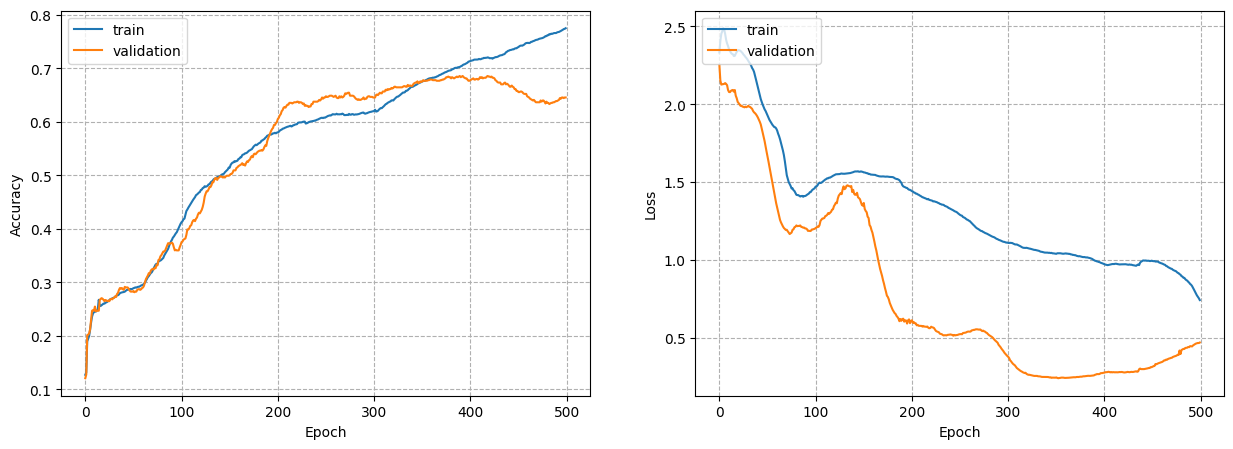

	Max validation accuracy: 68.5268 %
	Min validation loss: 0.23860


In [ ]:
show_results(history1)

In [ ]:
with open("history1_hnn_sgd_lre03_e500", "wb") as fp:
    pickle.dump(history1, fp)

### fold-2 <a name="fold-2"></a>

In [ ]:
FOLD_K = 2
REPEAT = 1

history2 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history2.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 13.3929%

Epoch 1/100
100%|██████████| 246/246 [00:04<00:00, 57.41it/s]
loss: 2.2617 - accuracy: 0.1118 - val_loss: 2.2663 - val_accuracy: 0.1339

Epoch 2/100
100%|██████████| 246/246 [00:04<00:00, 59.29it/s]
loss: 2.2240 - accuracy: 0.1883 - val_loss: 2.2283 - val_accuracy: 0.2210

Epoch 3/100
100%|██████████| 246/246 [00:04<00:00, 58.48it/s]
loss: 2.1734 - accuracy: 0.2078 - val_loss: 2.1755 - val_accuracy: 0.2388

Epoch 4/100
100%|██████████| 246/246 [00:04<00:00, 60.16it/s]
loss: 2.1330 - accuracy: 0.2124 - val_loss: 2.1305 - val_accuracy: 0.2388

Epoch 5/100
100%|██████████| 246/246 [00:04<00:00, 54.94it/s]
loss: 2.1019 - accuracy: 0.2180 - val_loss: 2.0928 - val_accuracy: 0.2400

Epoch 6/100
100%|██████████| 246/246 [00:04<00:00, 56.51it/s]
loss: 2.0804 - accuracy: 0.2259 - val_loss: 2.0681 - val_accuracy: 0.2467

Epoch 7/100
100%|██████████| 246/246 [00:04<00:00, 60.01it


(1)


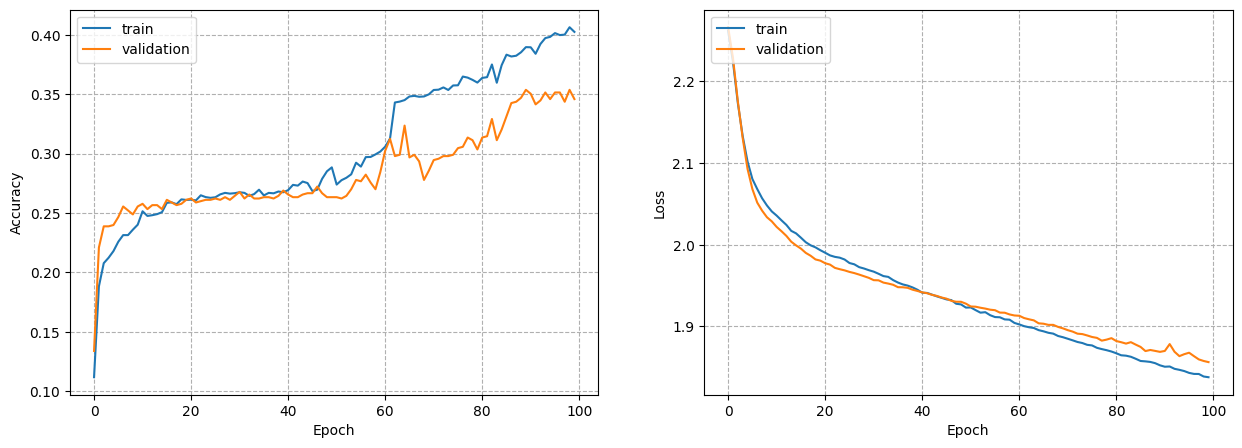

	Max validation accuracy: 35.3795 %
	Min validation loss: 1.85637


In [ ]:
show_results(history2)

In [ ]:
with open("history2_hnn", "wb") as fp:
    pickle.dump(history2, fp)

### fold-3 <a name="fold-3"></a>

In [ ]:
FOLD_K = 3
REPEAT = 1

history3 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=200, num_of_workers=4)
    history3.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 10.7759%

Epoch 1/200
100%|██████████| 244/244 [00:04<00:00, 59.52it/s]
loss: 2.2784 - accuracy: 0.1525 - val_loss: 2.2793 - val_accuracy: 0.1422

Epoch 2/200
100%|██████████| 244/244 [00:04<00:00, 59.52it/s]
loss: 2.2399 - accuracy: 0.1638 - val_loss: 2.2445 - val_accuracy: 0.1530

Epoch 3/200
100%|██████████| 244/244 [00:04<00:00, 59.18it/s]
loss: 2.1952 - accuracy: 0.1693 - val_loss: 2.2060 - val_accuracy: 0.1562

Epoch 4/200
100%|██████████| 244/244 [00:04<00:00, 59.72it/s]
loss: 2.1524 - accuracy: 0.1756 - val_loss: 2.1701 - val_accuracy: 0.1670

Epoch 5/200
100%|██████████| 244/244 [00:04<00:00, 57.10it/s]
loss: 2.1245 - accuracy: 0.1774 - val_loss: 2.1457 - val_accuracy: 0.1703

Epoch 6/200
100%|██████████| 244/244 [00:04<00:00, 59.86it/s]
loss: 2.1031 - accuracy: 0.2048 - val_loss: 2.1245 - val_accuracy: 0.1767

Epoch 7/200
100%|██████████| 244/244 [00:04<00:00, 59.24it


(1)


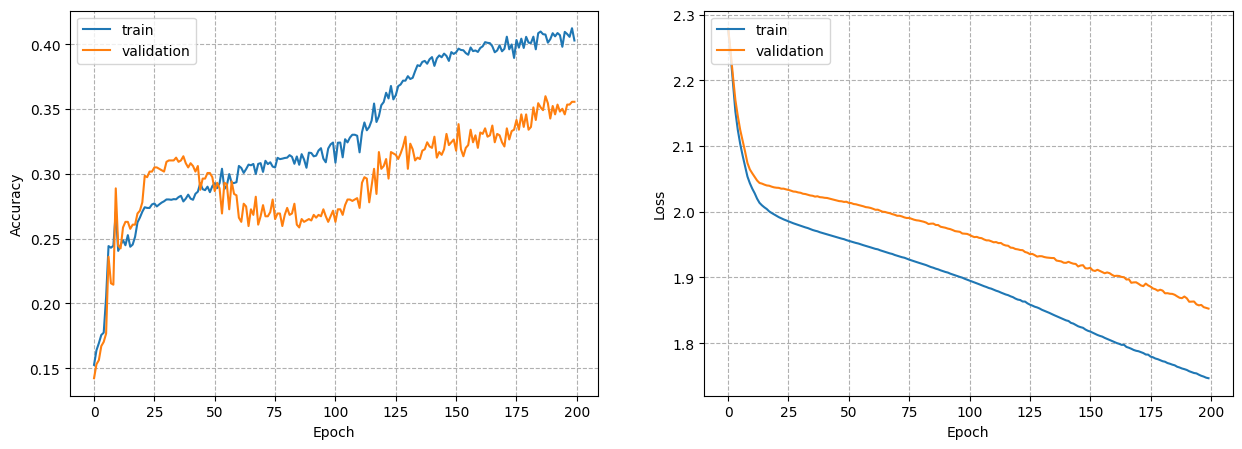

	Max validation accuracy: 35.9914 %
	Min validation loss: 1.85253


In [ ]:
show_results(history3)

In [ ]:
with open("history3", "wb") as fp:
    pickle.dump(history3, fp)

### fold-4 <a name="fold-4"></a>

In [ ]:
FOLD_K = 4
REPEAT = 1

history4 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history4.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 6.0484%

Epoch 1/100
100%|██████████| 242/242 [00:03<00:00, 61.90it/s]
loss: 2.2917 - accuracy: 0.1981 - val_loss: 2.2925 - val_accuracy: 0.1855

Epoch 2/100
100%|██████████| 242/242 [00:03<00:00, 60.60it/s]
loss: 2.2603 - accuracy: 0.2494 - val_loss: 2.2704 - val_accuracy: 0.2278

Epoch 3/100
100%|██████████| 242/242 [00:04<00:00, 58.56it/s]
loss: 2.1921 - accuracy: 0.2539 - val_loss: 2.2207 - val_accuracy: 0.2248

Epoch 4/100
100%|██████████| 242/242 [00:03<00:00, 62.13it/s]
loss: 2.1262 - accuracy: 0.2479 - val_loss: 2.1707 - val_accuracy: 0.1774

Epoch 5/100
100%|██████████| 242/242 [00:03<00:00, 60.97it/s]
loss: 2.0956 - accuracy: 0.2546 - val_loss: 2.1446 - val_accuracy: 0.1835

Epoch 6/100
100%|██████████| 242/242 [00:03<00:00, 61.82it/s]
loss: 2.0741 - accuracy: 0.2539 - val_loss: 2.1186 - val_accuracy: 0.1794

Epoch 7/100
100%|██████████| 242/242 [00:04<00:00, 59.12it/


(1)


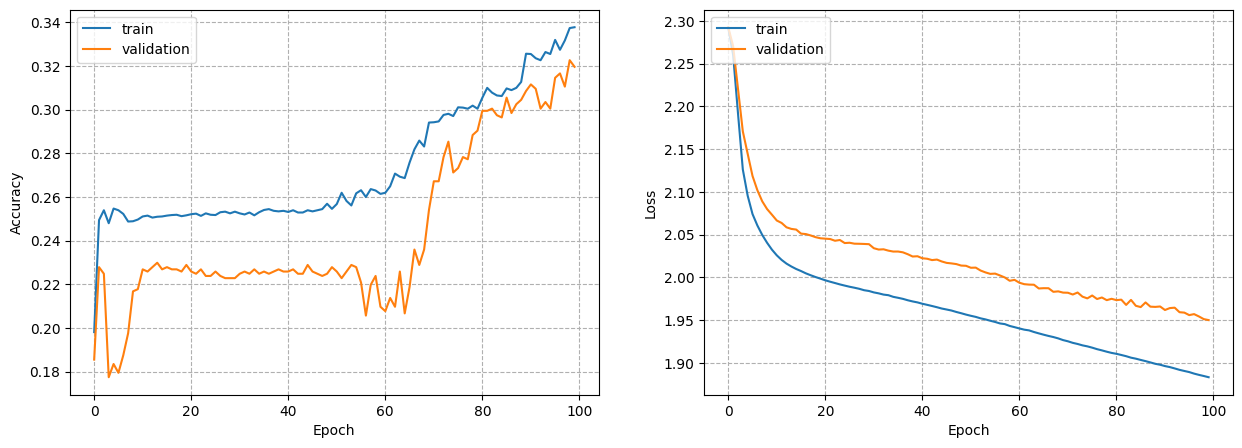

	Max validation accuracy: 32.2581 %
	Min validation loss: 1.95018


In [ ]:
show_results(history4)

In [ ]:
with open("history4_hnn_lre05", "wb") as fp:
    pickle.dump(history4, fp)

### fold-5 <a name="fold-5"></a>

In [ ]:
FOLD_K = 5
REPEAT = 3

history5 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history5.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 7.2917%

Epoch 1/100
100%|██████████| 244/244 [00:06<00:00, 38.08it/s]


In [ ]:
show_results(history5)

In [ ]:
with open("history5", "wb") as fp:
    pickle.dump(history5, fp)

### fold-6 <a name="fold-6"></a>

In [ ]:
FOLD_K = 6
REPEAT = 3

history6 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history6.append(history)

In [ ]:
show_results(history6)

In [ ]:
with open("history6", "wb") as fp:
    pickle.dump(history6, fp)

### fold-7 <a name="fold-7"></a>

In [ ]:
FOLD_K = 7
REPEAT = 3

history7 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history7.append(history)

In [ ]:
show_results(history7)

In [ ]:
with open("history7", "wb") as fp:
    pickle.dump(history7, fp)

### fold-8 <a name="fold-8"></a>

In [ ]:
FOLD_K = 8
REPEAT = 3

history8 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history8.append(history)

In [ ]:
show_results(history8)

In [ ]:
with open("history8", "wb") as fp:
    pickle.dump(history8, fp)

### fold-9 <a name="fold-9"></a>

In [ ]:
FOLD_K = 9
REPEAT = 3

history9 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history9.append(history)

In [ ]:
show_results(history9)

In [ ]:
with open("history9", "wb") as fp:
    pickle.dump(history9, fp)

### fold-10 <a name="fold-10"></a>

In [ ]:
FOLD_K = 10
REPEAT = 3

history10 = []

for i in range(REPEAT):
    print('-'*80)
    print("\n({})\n".format(i+1))

    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history10.append(history)

In [ ]:
show_results(history10)

In [ ]:
with open("history10", "wb") as fp:
    pickle.dump(history10, fp)

---

## 6. Results  <a name="sixth-bullet"></a>

In [ ]:
LOAD_HISTORY = True

if LOAD_HISTORY:
    with open("history1", "rb") as fp:
        history1 = pickle.load(fp)

    with open("history2", "rb") as fp:
        history2 = pickle.load(fp)

    with open("history3", "rb") as fp:
        history3 = pickle.load(fp)

    with open("history4", "rb") as fp:
        history4 = pickle.load(fp)

    with open("history5", "rb") as fp:
        history5 = pickle.load(fp)

    with open("history6", "rb") as fp:
        history6 = pickle.load(fp)

    with open("history7", "rb") as fp:
        history7 = pickle.load(fp)

    with open("history8", "rb") as fp:
        history8 = pickle.load(fp)

    with open("history9", "rb") as fp:
        history9 = pickle.load(fp)

    with open("history10", "rb") as fp:
        history10 = pickle.load(fp)

In [ ]:
tot_history = [history1, history2, history3, history4, history5, history6, history7, history8, history9, history10]

---

### I) Results for **min loss**
a) calculate total min loss for 10-fold cross validation

In [ ]:
avg_train_loss_per_fold = []
avg_val_loss_per_fold = []
std_train_loss_per_fold = []
std_val_loss_per_fold = []

tot_min_train_loss = 0.0
tot_min_val_loss = 0.0

# iterate over all folds
for fold_histories in tot_history:
    fold_min_train_losses = []
    fold_min_val_losses = []

    # collect min losses of all fold's histories
    for history in fold_histories:
        fold_min_train_losses.append(np.min(history['loss']))
        fold_min_val_losses.append(np.min(history['val_loss']))

    # avg min loss
    avg_train_loss_per_fold.append(np.mean(fold_min_train_losses))
    avg_val_loss_per_fold.append(np.mean(fold_min_val_losses))
    # std of min loss
    std_train_loss_per_fold.append(np.std(fold_min_train_losses))
    std_val_loss_per_fold.append(np.std(fold_min_val_losses))

    # add fold's avg min loss to sum of total loss
    tot_min_train_loss += np.mean(fold_min_train_losses)
    tot_min_val_loss += np.mean(fold_min_val_losses)

avg_min_train_loss = tot_min_train_loss / len(tot_history)
avg_min_val_loss = tot_min_val_loss / len(tot_history)

print("10-Fold Cross Validation\n")
print("Average train min loss: %.4f" % avg_min_train_loss)
print("Average validation min loss: %.4f" % avg_min_val_loss)

b) train and validation **min loss** for <ins>each fold</ins>

In [ ]:
print("train set (folds):", avg_train_loss_per_fold)
print("validation set (folds):", avg_val_loss_per_fold, '\n')

df = pd.DataFrame(data=zip(list(range(1,11)), avg_train_loss_per_fold, avg_val_loss_per_fold), columns=['fold', 'train', 'validation'])
df = pd.melt(df, id_vars="fold", var_name="set", value_name="loss")

sns_plot = sns.catplot(x='fold', y='loss', hue='set', data=df, kind='bar', height=5.27, aspect=10.7/5.27)
sns_plot.savefig('CV_loss.png')

---

### II) Results for **max accuracy**
a) calculate total max accuracy for 10-fold cross validation


In [ ]:
avg_train_acc_per_fold = []
avg_val_acc_per_fold = []
std_train_acc_per_fold = []
std_val_acc_per_fold = []

tot_max_train_acc = 0.0
tot_max_val_acc = 0.0

# iterate over all folds
for fold_histories in tot_history:
    fold_max_train_accs = []
    fold_max_val_accs = []

    # collect max accuracies of all fold's histories
    for history in fold_histories:
        fold_max_train_accs.append(np.max(history['accuracy']))
        fold_max_val_accs.append(np.max(history['val_accuracy']))

    # avg max accuracy
    avg_train_acc_per_fold.append(np.mean(fold_max_train_accs))
    avg_val_acc_per_fold.append(np.mean(fold_max_val_accs))
    # std of max accuracy
    std_train_acc_per_fold.append(np.std(fold_max_train_accs))
    std_val_acc_per_fold.append(np.std(fold_max_val_accs))

    # add fold's avg max accuracy to sum of total accuracy
    tot_max_train_acc += np.mean(fold_max_train_accs)
    tot_max_val_acc += np.mean(fold_max_val_accs)

avg_max_train_acc = tot_max_train_acc / len(tot_history)
avg_max_val_acc = tot_max_val_acc / len(tot_history)

print("10-Fold Cross Validation\n")
print("Average train max accuracy: %.4f %%" % (avg_max_train_acc * 100))
print("Average validation max accuracy: %.4f %%" % (avg_max_val_acc * 100))

b) train and validation **max accuracy** <ins>for each fold</ins>

In [ ]:
print("train set (folds):", avg_train_acc_per_fold)
print("validation set (folds):", avg_val_acc_per_fold, '\n')

df = pd.DataFrame(data=zip(list(range(1,11)), avg_train_acc_per_fold, avg_val_acc_per_fold), columns=['fold', 'train', 'validation'])
df = pd.melt(df, id_vars="fold", var_name="set", value_name="accuracy")

sns_plot = sns.catplot(x='fold', y='accuracy', hue='set', data=df, kind='bar', height=5.27, aspect=10.7/5.27)
sns_plot.savefig('CV_accuracy.png')

---

### III) Standard deviation (per fold)

a) loss

In [ ]:
print(std_train_loss_per_fold)
print(std_val_loss_per_fold)

b) accuracy

In [ ]:
print(std_train_acc_per_fold)
print(std_val_acc_per_fold)